<a href="https://colab.research.google.com/github/APWright/6242Project/blob/master/Analysis/6242.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import sklearn
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
import seaborn as sns
sns.set_style("darkgrid")
from pygam import InvGaussGAM, GAM, LinearGAM, s, f
import warnings
import pickle
warnings.simplefilter('ignore')
#import networkx

### Load all datasets

In [6]:
# Load all node level data
codes = pd.read_csv("../Data/iso_codes_numeric_abbrevs.csv")
data_index = ['src_num', 'src_abb', 'tgt_num', 'tgt_abb', 'year']

democracy_score = pd.read_csv("../Data/Democracy-Autocracy-score-csv.csv")
gdp_score = pd.read_csv("../Data/GDP_per_cap_clean_rev2.csv").rename(columns={'origin_abb':'src_abb','origin_num':'src_num','dest_num':'tgt_num','dest_abb':'tgt_abb'})
avg_temp = pd.read_csv("../Data/average_temp_country.csv").rename(columns={'origin_abb':'src_abb','origin_numeric':'src_num','destination_numeric':'tgt_num','destination_abb':'tgt_abb'})
avg_school_years = pd.read_csv("../Data/avg_school_years_imputeclosest.csv")
birth_rates = pd.read_csv("../Data/birth_rates.csv")
land_locked = pd.read_csv("../Data/country_land_locked_clean.csv")
water_scaricity = pd.read_csv("../Data/country_water_scarcity_clean.csv")
natural_disasters = pd.read_csv("../Data/natural_disaster_clean.csv")

population = pd.read_csv("../Data/population-csv.csv").rename(columns={'Country Code':'src_abb','Numeric code':'src_num'}).drop(["Country Name",'src_abb'],axis=1).melt(id_vars=['src_num'],var_name='year',value_name='population').dropna()
population['year'] = population['year'].astype(int)
population['population'] = population['population'].astype(int)

node_features = pd.merge(democracy_score,gdp_score, on=data_index,how='outer')
node_features = pd.merge(node_features,avg_temp, on=data_index,how='outer').drop(['Unnamed: 0',"Name"],axis=1).rename(columns={'avg':'avg_temp'})
node_features = pd.merge(node_features,avg_school_years, on=data_index,how='outer')
node_features = pd.merge(node_features,birth_rates, on=data_index,how='outer')
node_features = pd.merge(node_features,land_locked, on=data_index,how='outer').drop(['Unnamed: 0',"Country"],axis=1)
water_scaricity['Risk_Level'] = water_scaricity['Risk_Level'].map(lambda rl: {'Extremely-high':5, 'High':4, 'Low':1, 'Low-medium':2, 'Medium-high':3}[rl])
node_features = pd.merge(node_features,water_scaricity, on=data_index,how='outer').drop(['Unnamed: 0','Rank ',"Country",'Extremely-high', 'High', 'Low', 'Low-medium', 'Medium-high'],axis=1).rename(columns={'Risk_Level':'water_risk'})
node_features = pd.merge(node_features,natural_disasters, on=data_index,how='outer').drop(['Unnamed: 0',"Country","Prone_Disasters"],axis=1)
node_features = node_features.drop(['src_abb', 'tgt_num', 'tgt_abb'],axis=1)
node_features = population.merge(node_features,on=['src_num','year'],how='outer')
node_features = node_features.fillna(0)

In [8]:
# Load all edge level data
trade = pd.read_csv("../Data/trade_depencies_rev2.zip").rename(columns={'origin_abb':'src_abb','origin_num':'src_num','dest_num':'tgt_num','dest_abb':'tgt_abb'}).dropna()
trade['year'] = trade['year'].astype(int)
conflict = pd.read_csv("../Data/ucdp_conflict_rev2.zip").rename(columns={'year0':'year','orig':'src_abb','orig_code':'src_num','dest_code':'tgt_num','dest':'tgt_abb','intensity_level':'conflict'})
contiguous_states = pd.read_csv("../Data/contiguous_states_rev2.zip").rename(columns={'year0':'year','orig':'src_abb','orig_code':'src_num','dest_code':'tgt_num','dest':'tgt_abb'})
edge_features = conflict.merge(trade,on=data_index,how='outer').merge(contiguous_states,on=data_index,how='outer')

edge_inv = edge_features.rename(columns={'src_abb':'tgt_abb','src_num':'tgt_num','tgt_abb':'src_abb','tgt_num':'src_num'})
edge_features = pd.merge(edge_features,edge_inv,on=data_index,how='outer',suffixes=('','_inv'))
edge_features.fillna(0)

migration = pd.read_csv("../Data/migration_flows_all_years.csv",index_col=0).rename(columns={'year0':'year',
                                                                                                       'orig': 'src_abb',
                                                                                                       'dest':'tgt_abb',
                                                                                                   'orig_code':'src_num',
                                                                                                       'dest_code':'tgt_num'})
migration['year'] = migration['year'].map(lambda t: int(t[:4]))

In [9]:
# View summary stats of each variable
def print_stats(feat):
  print("\n")
  print(feat)
  if len(np.unique(node_features[feat])) < 20:
    print("categories: ", np.unique(node_features[feat]))
  print("mean:", np.mean(node_features[feat]),"stdev:", np.std(node_features[feat]))

for feat in node_features.columns[2:]:
    print_stats(feat)



population
mean: 11356500.567189708 stdev: 70714482.87353331


democ
categories:  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
mean: 2.143972633301108 stdev: 3.4970827751836437


autoc
categories:  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
mean: 2.144270097419499 stdev: 3.2035401423763874


GDP_per_cap
mean: 2538.110296439759 stdev: 8168.556048584422


avg_temp
mean: 16.24203779190525 stdev: 10.066144182002795


years_in_school
mean: 2.5419031754294634 stdev: 3.557241664022907


birth_rateper1000
mean: 11.861670389851044 stdev: 16.582010476289753


LandLocked
categories:  [0. 1.]
mean: 0.16598497806202128 stdev: 0.37206715135815416


water_risk
categories:  [0. 1. 2. 3. 4. 5.]
mean: 1.6178329738975237 stdev: 1.6475776335773498


snow
categories:  [0. 1.]
mean: 0.008923923551721573 stdev: 0.09404407020203136


tsunami
categories:  [0. 1.]
mean: 0.05800550308619023 stdev: 0.23375385493700038


tornado
categories:  [0. 1.]
mean: 0.008923923551721573 stdev: 0.09404407020203136


ava

### Prepocess and concatenate all data

In [10]:
# Find start and end years
start_year = min(np.unique(migration['year']))
end_year = max(np.unique(migration['year']))
print("start_year:", start_year, "end_year:", end_year)

start_year: 1960 end_year: 2014


In [11]:
# Trim data to start and end years
node_features = node_features[node_features['year'] >= start_year]
node_features = node_features[node_features['year'] <= end_year]
edge_features = edge_features[edge_features['year'] >= start_year]
edge_features = edge_features[edge_features['year'] <= end_year]

In [12]:
# Concatenate datasets into one large df
regression_df = pd.merge(edge_features,node_features,on=['src_num','year'],how='outer')
regression_df = pd.merge(regression_df,node_features,left_on=['tgt_num','year'],right_on=['src_num','year'],suffixes=('_src','_tgt'),how='outer')
regression_df = regression_df.drop(['src_num_tgt'],axis=1)
regression_df = regression_df.rename(columns={'src_num_src':'src_num'})
regression_df = regression_df.fillna(0)
regression_df

year src_abb tgt_abb  src_num  tgt_num  conflict  trade_dependence  \
0        1960     ABW     ABW    533.0    533.0       0.0      0.000000e+00   
1        1960     AFG     ABW      4.0    533.0       0.0      0.000000e+00   
2        1960     AGO     ABW     24.0    533.0       0.0      6.703448e-08   
3        1960     ALB     ABW      8.0    533.0       0.0      1.222307e-05   
4        1960     ARE     ABW    784.0    533.0       0.0      6.476933e-06   
...       ...     ...     ...      ...      ...       ...               ...   
2088733  2010       0       0      0.0      0.0       0.0      0.000000e+00   
2088734  2011       0       0      0.0      0.0       0.0      0.000000e+00   
2088735  2012       0       0      0.0      0.0       0.0      0.000000e+00   
2088736  2013       0       0      0.0      0.0       0.0      0.000000e+00   
2088737  2014       0       0      0.0      0.0       0.0      0.000000e+00   

         conttype  conflict_inv  trade_dependence_inv  ...  water_risk_tgt  \
0             0.0           0.0          0.000000e+00  ...             0.0   
1             0.0           0.0          2.633481e-04  ...             0.0   
2             0.0           0.0          0.000000e+00  ...             0.0   
3             0.0           0.0          1.103166e-07  ...             0.0   
4             0.0           0.0          8.306788e-05  ...             0.0   
...           ...           ...                   ...  ...             ...   
2088733       0.0           0.0          0.000000e+00  ...             0.0   
2088734       0.0           0.0          0.000000e+00  ...             0.0   
2088735       0.0           0.0          0.000000e+00  ...             0.0   
2088736       0.0           0.0          0.000000e+00  ...             0.0   
2088737       0.0           0.0          0.000000e+00  ...             0.0   

         snow_tgt  tsunami_tgt  tornado_tgt  avalanche_tgt  fire_tgt  \
0             0.0          0.0          0.0            0.0       1.0   
1             0.0          0.0          0.0            0.0       1.0   
2             0.0          0.0          0.0            0.0       1.0   
3             0.0          0.0          0.0            0.0       1.0   
4             0.0          0.0          0.0            0.0       1.0   
...           ...          ...          ...            ...       ...   
2088733       0.0          0.0          0.0            0.0       0.0   
2088734       0.0          0.0          0.0            0.0       0.0   
2088735       0.0          0.0          0.0            0.0       0.0   
2088736       0.0          0.0          0.0            0.0       0.0   
2088737       0.0          0.0          0.0            0.0       0.0   

         severe_storms_tgt  mudslide_tgt  icestorms_tgt  tropical_storms_tgt  
0                      0.0           0.0            0.0                  0.0  
1                      0.0           0.0            0.0                  0.0  
2                      0.0           0.0            0.0                  0.0  
3                      0.0           0.0            0.0                  0.0  
4                      0.0           0.0            0.0                  0.0  
...                    ...           ...            ...                  ...  
2088733                0.0           0.0            0.0                  0.0  
2088734                0.0           0.0            0.0                  0.0  
2088735                0.0           0.0            0.0                  0.0  
2088736                0.0           0.0            0.0                  0.0  
2088737                0.0           0.0            0.0                  0.0  

[2088738 rows x 47 columns]

In [13]:
total_regression_df = pd.merge(migration,regression_df,on=data_index)
total_regression_df = total_regression_df.fillna(0.0)
total_regression_df

year src_abb tgt_abb  src_num  tgt_num  flow  conflict  \
0        1960     ABW     ABW      533      533   0.0       0.0   
1        1961     ABW     ABW      533      533   0.0       0.0   
2        1962     ABW     ABW      533      533   0.0       0.0   
3        1963     ABW     ABW      533      533   0.0       0.0   
4        1964     ABW     ABW      533      533   0.0       0.0   
...       ...     ...     ...      ...      ...   ...       ...   
2088697  2010     ZWE     ZWE      716      716   0.0       0.0   
2088698  2011     ZWE     ZWE      716      716   0.0       0.0   
2088699  2012     ZWE     ZWE      716      716   0.0       0.0   
2088700  2013     ZWE     ZWE      716      716   0.0       0.0   
2088701  2014     ZWE     ZWE      716      716   0.0       0.0   

         trade_dependence  conttype  conflict_inv  ...  water_risk_tgt  \
0                     0.0       0.0           0.0  ...             0.0   
1                     0.0       0.0           0.0  ...             0.0   
2                     0.0       0.0           0.0  ...             0.0   
3                     0.0       0.0           0.0  ...             0.0   
4                     0.0       0.0           0.0  ...             0.0   
...                   ...       ...           ...  ...             ...   
2088697               0.0       0.0           0.0  ...             2.0   
2088698               0.0       0.0           0.0  ...             2.0   
2088699               0.0       0.0           0.0  ...             2.0   
2088700               0.0       0.0           0.0  ...             2.0   
2088701               0.0       0.0           0.0  ...             2.0   

         snow_tgt  tsunami_tgt  tornado_tgt  avalanche_tgt  fire_tgt  \
0             0.0          0.0          0.0            0.0       1.0   
1             0.0          0.0          0.0            0.0       1.0   
2             0.0          0.0          0.0            0.0       1.0   
3             0.0          0.0          0.0            0.0       1.0   
4             0.0          0.0          0.0            0.0       1.0   
...           ...          ...          ...            ...       ...   
2088697       0.0          0.0          0.0            0.0       0.0   
2088698       0.0          0.0          0.0            0.0       0.0   
2088699       0.0          0.0          0.0            0.0       0.0   
2088700       0.0          0.0          0.0            0.0       0.0   
2088701       0.0          0.0          0.0            0.0       0.0   

         severe_storms_tgt  mudslide_tgt  icestorms_tgt  tropical_storms_tgt  
0                      0.0           0.0            0.0                  0.0  
1                      0.0           0.0            0.0                  0.0  
2                      0.0           0.0            0.0                  0.0  
3                      0.0           0.0            0.0                  0.0  
4                      0.0           0.0            0.0                  0.0  
...                    ...           ...            ...                  ...  
2088697                1.0           0.0            0.0                  0.0  
2088698                1.0           0.0            0.0                  0.0  
2088699                1.0           0.0            0.0                  0.0  
2088700                1.0           0.0            0.0                  0.0  
2088701                1.0           0.0            0.0                  0.0  

[2088702 rows x 48 columns]

### Fit GAM and baseline linear regression

In [14]:
# Split data into train/test
y = np.log(total_regression_df['flow']+1.0)
X = total_regression_df[total_regression_df.columns[6:]].values
train_index = (np.random.rand(len(y)) <= 0.5) & (y > 0.1)
test_index  = ~train_index & (y > 0.1)

In [ ]:
# Fit gam and linear regression
gam = LinearGAM()
gam = gam.fit(X[train_index],y[train_index])
baseline = linear_model.LinearRegression(normalize=True).fit(X[train_index],y[train_index])

In [15]:
gam = LinearGAM()

In [16]:
# Save model to disk under Models/ dir 
save_model= open("Models/gam.pkl",mode='wb')
pickle.dump(gam,save_model)

### Evaluate fit
#### Quantitative analysis

In [19]:
# Load model
load_model =  open("Models/gam.pkl",mode='rb')
gam = pickle.load(load_model)

In [0]:
# Calculate pearson r correlation coef and p-val for training estimated response and actual response
scipy.stats.pearsonr(gam.predict(X[train_index]),y[train_index])

(0.6079533557164113, 0.0)

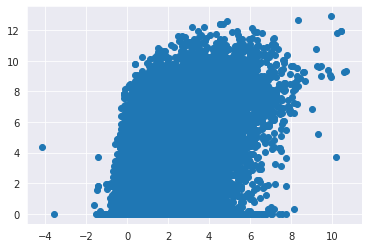

In [0]:
plt.scatter(gam.predict(X[train_index]),y[train_index])

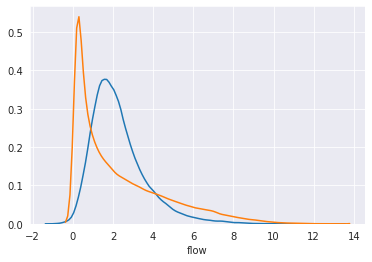

In [0]:
# Plot distributions of predicted and actual training response
sns.distplot(gam.predict(X[train_index]), hist=False)
sns.distplot(y[train_index], hist=False)

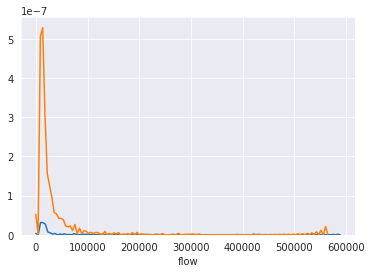

In [0]:
sns.distplot(np.exp(gam.predict(X[train_index])) ,hist=False)
sns.distplot(np.exp(y[train_index]),hist=False)

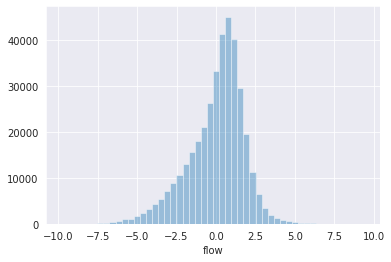

In [0]:
# Plot distribution of training estimated response minus actual response
sns.distplot(gam.predict(X[train_index]) - y[train_index],kde=False)

In [0]:
# Predict on test dataset
pred, y_test = gam.predict(X[test_index]), y[test_index]

In [0]:
np.std(y_test), np.std(pred - y_test)

(2.2459201578216494, 1.782221983854281)

In [0]:
np.var(pred - y_test)/np.var(y_test)

0.629701846313341

In [2]:
sklearn.metrics.r2_score(y_test,pred,multioutput='variance_weighted')

In [0]:
np.mean((pred - y_test)**2)

3.1763193788097444

In [0]:
np.sqrt(np.mean((np.exp(pred) - np.exp(y_test))**2))

5626.2519747863

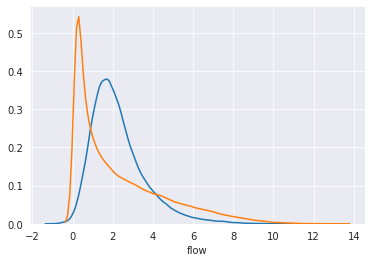

In [0]:
# Plot distributions of predicted and actual testing response
sns.distplot(pred,hist=False)
sns.distplot(y_test,hist=False)

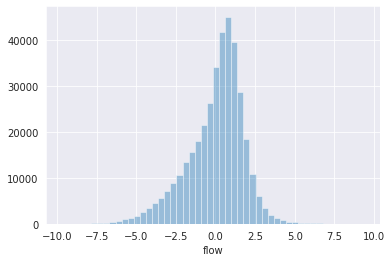

In [0]:
# Plot distribution of testing estimated response minus actual response
sns.distplot((pred - y_test),kde=False)

In [0]:
# Calculate pearson r correlation coef and p-val for testing estimated response and actual response
scipy.stats.pearsonr(pred,y_test)

(0.6085235338595003, 0.0)

In [0]:
scipy.stats.f_oneway(pred,y_test)

F_onewayResult(statistic=0.22807033298316595, pvalue=0.6329584923603307)

#### Qualitative analysis

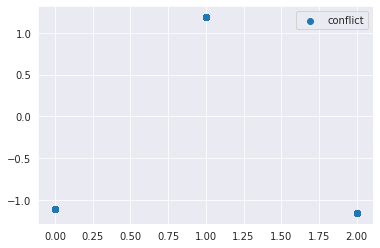

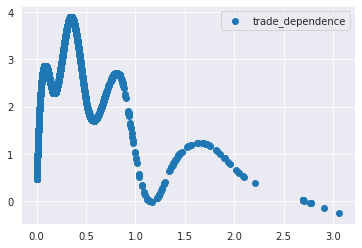

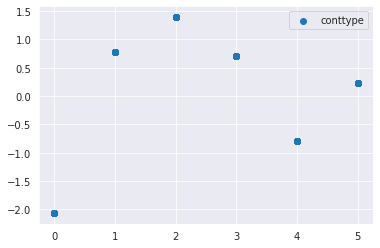

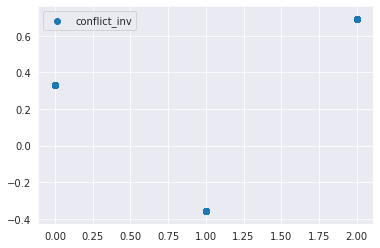

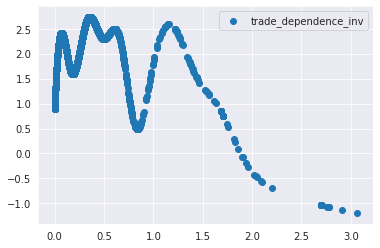

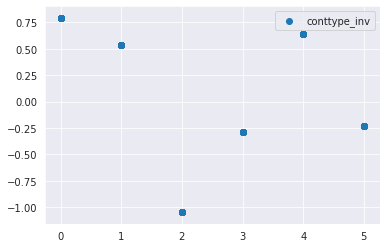

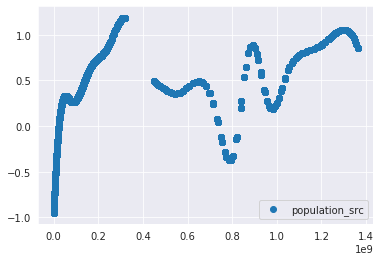

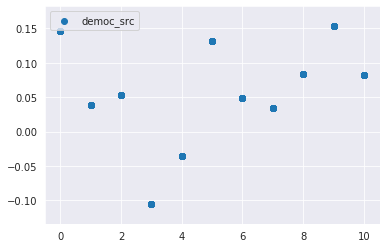

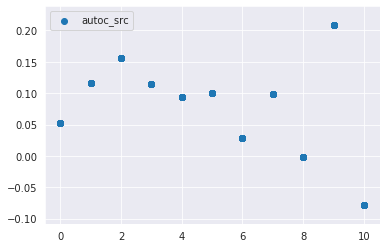

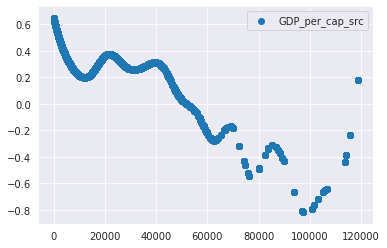

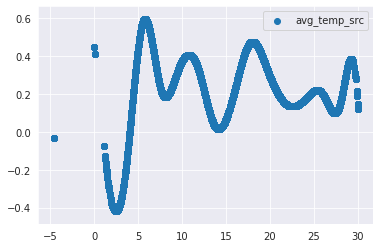

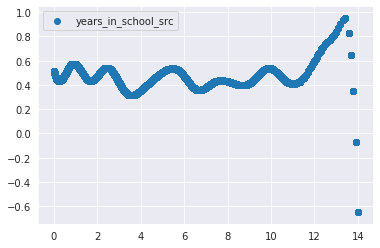

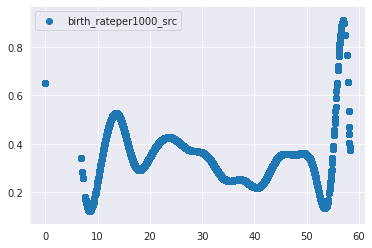

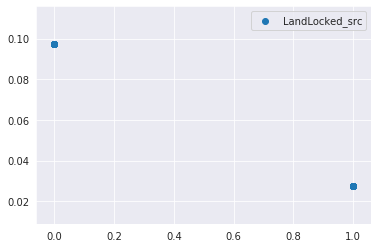

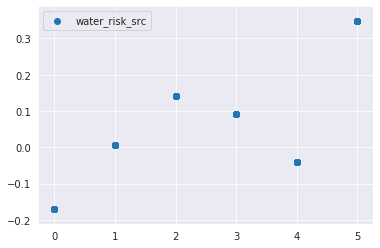

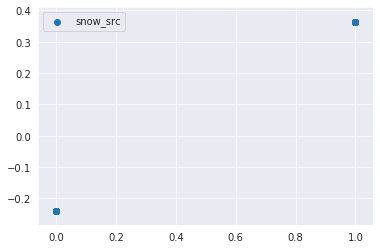

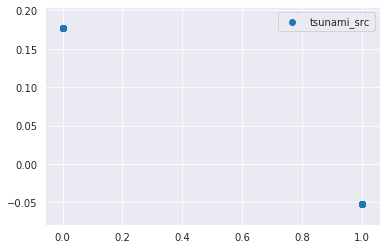

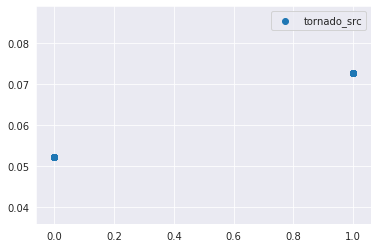

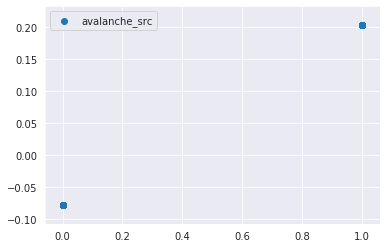

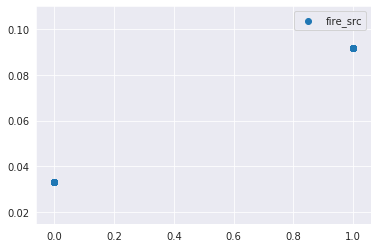

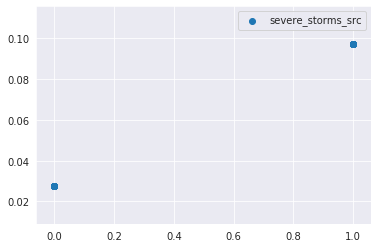

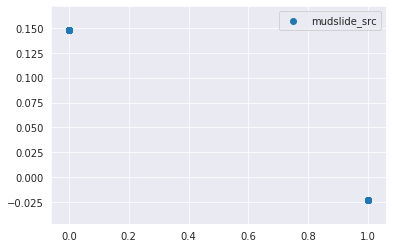

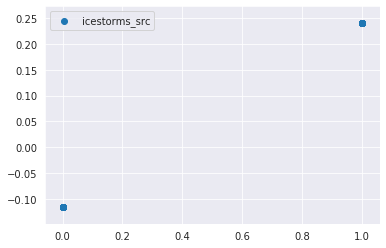

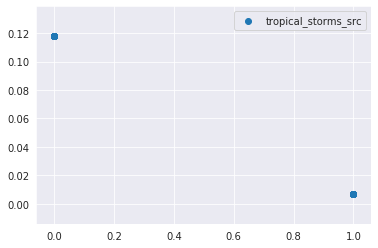

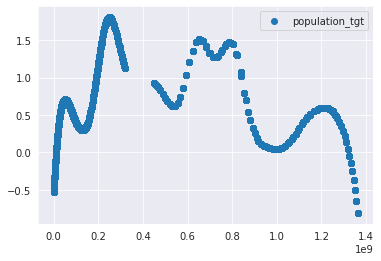

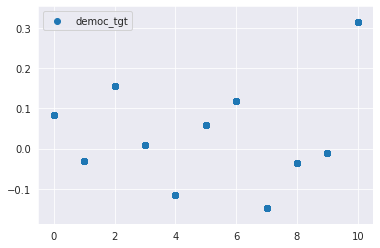

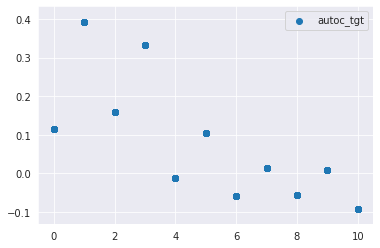

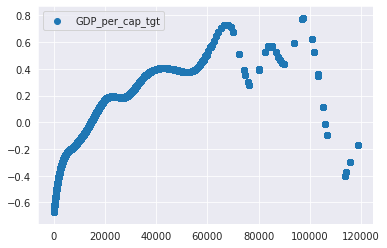

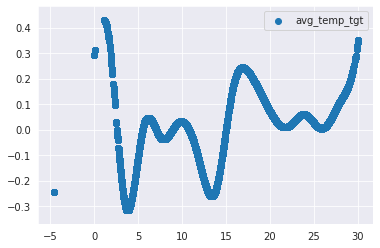

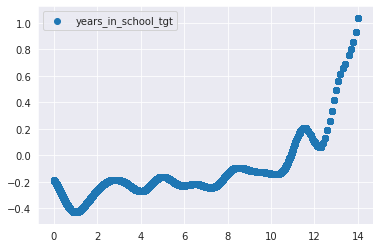

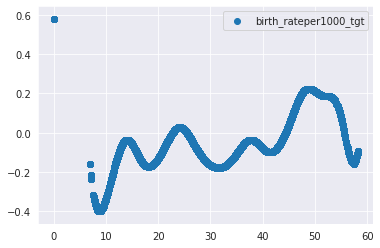

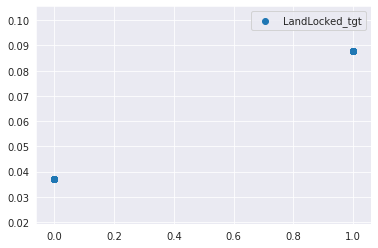

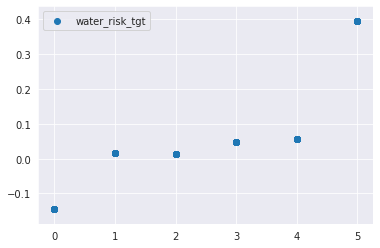

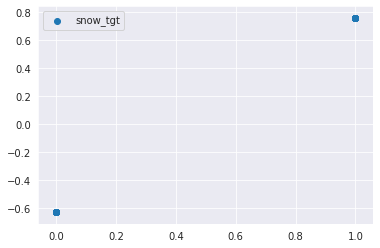

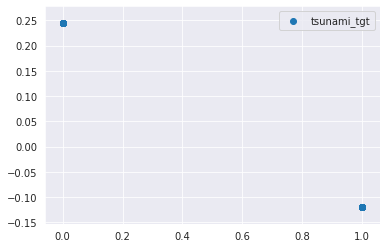

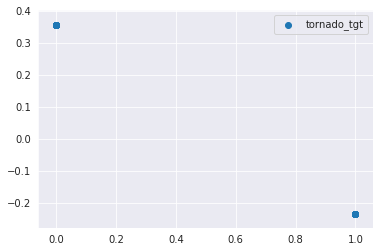

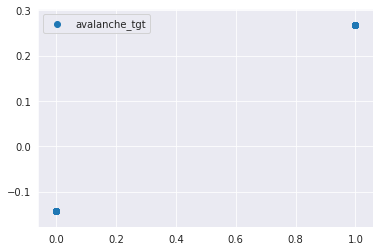

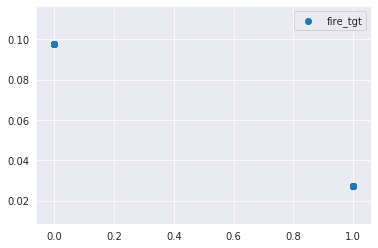

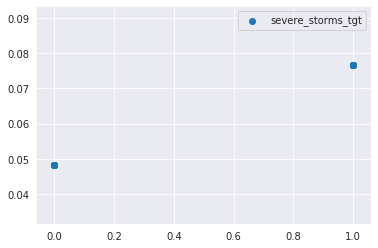

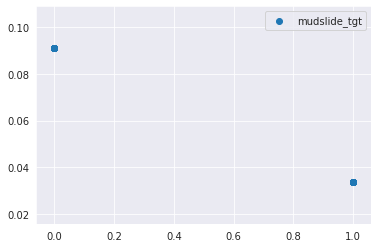

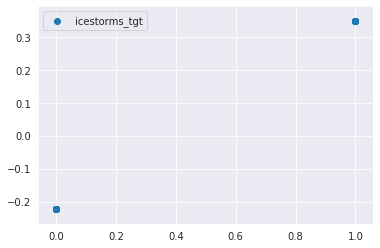

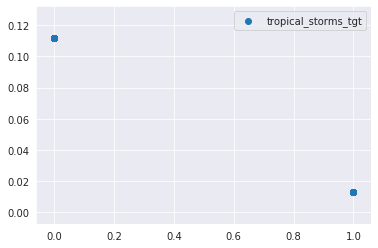

In [0]:
# Plot relationship between each predictor variable and response
plt.figure()
for i, term in enumerate(gam.terms):
    if i < 0:
      continue
    if term.isintercept:
        continue
    plt.scatter(X[:,i],gam.partial_dependence(term=i,X=X),label=total_regression_df.columns[6:][i])
    plt.legend()
    plt.show()

In [0]:
# Study exmaple migration from CAN to USA
codes[codes.iso_abb == 'CAN']

iso_abb  iso_numeric iso_country
29     CAN          124      Canada

In [0]:
total_regression_df[total_regression_df.src_num == 124][total_regression_df.tgt_num == 840][total_regression_df.year == 2011]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


year src_abb tgt_abb  ...  mudslide_tgt  icestorms_tgt  tropical_storms_tgt
321127  2011     CAN     USA  ...           0.0            0.0                  0.0

[1 rows x 48 columns]

(-1.1849481311494172, 'conflict')
(3.9755223170905873, 'trade_dependence')
(0.5608065189765301, 'conttype')
(0.20433512162244788, 'conflict_inv')
(2.5422749396407696, 'trade_dependence_inv')
(0.7471529235423021, 'conttype_inv')
(0.2520206463835875, 'population_src')
(0.09866119493744475, 'democ_src')
(0.05565900058920391, 'autoc_src')
(0.0472921674218544, 'GDP_per_cap_src')
(0.06795573552407386, 'avg_temp_src')
(0.760479326327987, 'years_in_school_src')
(0.2761075850204171, 'birth_rateper1000_src')
(0.09566644325151008, 'LandLocked_src')
(0.009168638358811243, 'water_risk_src')
(0.35803704295359784, 'snow_src')
(0.1856652350503522, 'tsunami_src')
(0.044100733231156854, 'tornado_src')
(-0.08975891860519965, 'avalanche_src')
(0.03806397756802556, 'fire_src')
(0.0990547001470127, 'severe_storms_src')
(0.14538969888879766, 'mudslide_src')
(-0.08928012668222106, 'icestorms_src')
(0.11852322415856471, 'tropical_storms_src')
(1.2347829791252465, 'population_tgt')
(0.33101821923082264, 'democ_

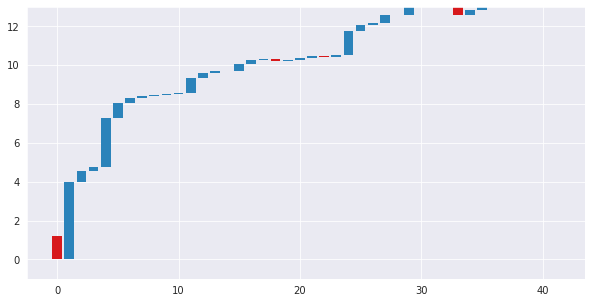

In [0]:
# Build GAM chart for CAN -> USA
for j in [321127]:
  plt.figure(figsize=(10,5))
  locs = [i for i in range(len(gam.terms)-1)]
  factors=np.array([gam.partial_dependence(term=i,X=X[j].reshape(1,-1)) for i in range(len(gam.terms)-1)]).ravel()
  [print(t) for t in zip(factors, total_regression_df.columns[6:])]
  cum_factors = [gam.coef_[-1]]
  for factor in factors:
    cum_factors.append(factor+cum_factors[-1])
  cum_factors = cum_factors[:-1]
  c = ['#d7191c' if f<0 else '#2b83ba' for f in factors]
  plt.bar(locs,factors,bottom=cum_factors,color=c,linewidth=0)
  # plt.bar([locs[-1]+1],[2*1.88],bottom=[pred[j]-1.88])
  # plt.axhline(y=y[j],c='r',label='Flow')
  # plt.axhline(y=pred[j],label="Prediction")
  # plt.axhline(y=gam.coef_[-1],c='w')
  plt.ylim(-1,13)
  # plt.legend()
  plt.show()

In [0]:
factors=np.array([gam.partial_dependence(term=i,X=X.reshape(-1,42)) for i in range(len(gam.terms)-1)]).T
factors.shape

(2088702, 42)

In [0]:
factor_df = pd.DataFrame(data=factors,columns=total_regression_df.columns[6:])

In [0]:
factor_df

conflict  trade_dependence  ...  icestorms_tgt  tropical_storms_tgt
0        1.861284         -0.241289  ...      -0.280626             0.053997
1        1.861284         -0.241289  ...      -0.280626             0.053997
2        1.861284         -0.241289  ...      -0.280626             0.053997
3        1.861284         -0.241289  ...      -0.280626             0.053997
4        1.861284         -0.241289  ...      -0.280626             0.053997
...           ...               ...  ...            ...                  ...
2088697  1.861284         -0.241289  ...      -0.280626             0.053997
2088698  1.861284         -0.241289  ...      -0.280626             0.053997
2088699  1.861284         -0.241289  ...      -0.280626             0.053997
2088700  1.861284         -0.241289  ...      -0.280626             0.053997
2088701  1.861284         -0.241289  ...      -0.280626             0.053997

[2088702 rows x 42 columns]

In [0]:
total_regression_df = total_regression_df.reset_index()
total_regression_df

index  year  ... icestorms_tgt tropical_storms_tgt
0              0  1960  ...           0.0                 0.0
1              1  1961  ...           0.0                 0.0
2              2  1962  ...           0.0                 0.0
3              3  1963  ...           0.0                 0.0
4              4  1964  ...           0.0                 0.0
...          ...   ...  ...           ...                 ...
2088697  2088697  2010  ...           0.0                 0.0
2088698  2088698  2011  ...           0.0                 0.0
2088699  2088699  2012  ...           0.0                 0.0
2088700  2088700  2013  ...           0.0                 0.0
2088701  2088701  2014  ...           0.0                 0.0

[2088702 rows x 49 columns]

In [0]:
master_df = total_regression_df.join(factor_df,rsuffix="_factor")
master_df = master_df.drop(columns=['index'])
master_df['bias_factor'] = gam.coef_[-1]
master_df['log_prediction'] = pred
master_df['flow_prediction'] = np.exp(pred)
master_df['log_prediction_accuracy_sigma'] = np.std(pred - y)
master_df

year src_abb  ... flow_prediction  log_prediction_accuracy_sigma
0        1960     ABW  ...        0.922080                       1.424926
1        1961     ABW  ...        0.905007                       1.424926
2        1962     ABW  ...        0.899422                       1.424926
3        1963     ABW  ...        0.905322                       1.424926
4        1964     ABW  ...        0.916116                       1.424926
...       ...     ...  ...             ...                            ...
2088697  2010     ZWE  ...        1.324123                       1.424926
2088698  2011     ZWE  ...        1.346114                       1.424926
2088699  2012     ZWE  ...        1.506310                       1.424926
2088700  2013     ZWE  ...        2.315426                       1.424926
2088701  2014     ZWE  ...        2.277524                       1.424926

[2088702 rows x 94 columns]

In [0]:
# Save output df to disk
master_df.to_csv('../InteractiveViz/master_table.csv',index=False,float_format='%.2f')